In [1]:
import os 
import math
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
# import seaborn as sns
%matplotlib inline

data_folder = '../data/'

# Data Descroption
Plot the data points location distribution

In [2]:
columns = ['RELI', 'EAST', 'NORTH']

location_data = pd.read_csv(os.path.join(data_folder, 'cross_with_neighbour.csv'), usecols=columns)
location_data.set_index('RELI', inplace=True)
location_data.head()

,EAST,NORTH
RELI,,
73012621,2730100,1262100
71932615,2719300,1261500
74942622,2749400,1262200
73102619,2731000,1261900
73342625,2733400,1262500


<AxesSubplot:xlabel='EAST', ylabel='NORTH'>

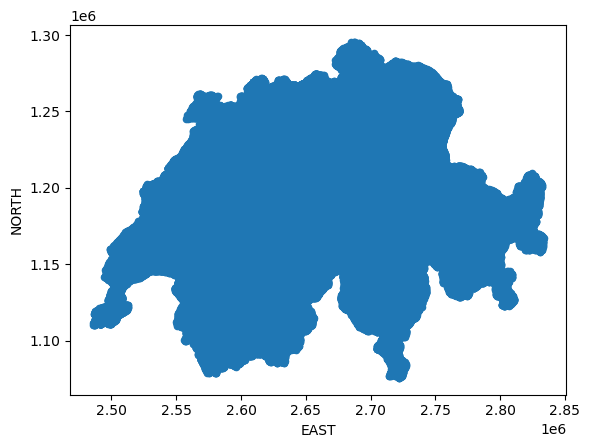

In [4]:
location_data.plot(x='EAST', y='NORTH', kind='scatter')

# Logistic Regression

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

In [3]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1', 'nbr5_LU3', 'nbr5_LC3', 'nbr5_LU2', 'nbr5_LC2', 'nbr5_LU1', 'nbr5_LC1', 'nbr6_LU3', 'nbr6_LC3',
           'nbr6_LU2', 'nbr6_LC2', 'nbr6_LU1', 'nbr6_LC1', 'nbr7_LU3', 'nbr7_LC3', 'nbr7_LU2', 'nbr7_LC2', 'nbr7_LU1',
           'nbr7_LC1', 'nbr8_LU3', 'nbr8_LC3', 'nbr8_LU2', 'nbr8_LC2', 'nbr8_LU1', 'nbr8_LC1']

original_data = pd.read_csv(os.path.join(data_folder, 'cross_with_neighbour.csv'), index_col=0)
original_data = original_data[columns]
original_data.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,...,nbr7_LU2,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1
RELI,,,,,,,,,,,,,,,,,,,,,
73012621,LU107,LC11,LU107,LC11,LU107,LC11,LU107,LC11,LU107,LC12,...,LU223,LC21,LU222,LC21,LU201,LC47,LU201,LC47,LU201,LC47
71932615,LU124,LC21,LU124,LC21,LU124,LC21,LU124,LC21,LU223,LC21,...,LU222,LC21,LU222,LC21,LU222,LC21,LU222,LC21,LU222,LC21
74942622,LU122,LC11,LU122,LC11,LU122,LC11,LU122,LC11,LU223,LC21,...,LU122,LC31,LU222,LC21,LU222,LC21,LU222,LC21,LU222,LC21
73102619,LU201,LC21,LU201,LC21,LU201,LC44,LU201,LC44,LU221,LC21,...,LU107,LC11,LU107,LC11,LU221,LC21,LU221,LC21,LU221,LC21
73342625,LU222,LC21,LU223,LC21,LU223,LC21,LU223,LC21,LU301,LC42,...,LU201,LC44,LU201,LC44,LU222,LC21,LU222,LC21,LU222,LC21


In [4]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The number of rows without nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 348474
The number of rows without nan value is: 348474


In [5]:
data_features = original_data.copy()
data_features['changed'] = [0 if row['LU4'] == row['LU3'] and row['LC4'] == row['LC3'] else 1 for ind, row in data_features[['LU4', 'LC4', 'LU3', 'LC3']].iterrows()]
data_features.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,...,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1,changed
RELI,,,,,,,,,,,,,,,,,,,,,
73012621,LU107,LC11,LU107,LC11,LU107,LC11,LU107,LC11,LU107,LC12,...,LC21,LU222,LC21,LU201,LC47,LU201,LC47,LU201,LC47,0
71932615,LU124,LC21,LU124,LC21,LU124,LC21,LU124,LC21,LU223,LC21,...,LC21,LU222,LC21,LU222,LC21,LU222,LC21,LU222,LC21,0
74942622,LU122,LC11,LU122,LC11,LU122,LC11,LU122,LC11,LU223,LC21,...,LC31,LU222,LC21,LU222,LC21,LU222,LC21,LU222,LC21,0
73102619,LU201,LC21,LU201,LC21,LU201,LC44,LU201,LC44,LU221,LC21,...,LC11,LU107,LC11,LU221,LC21,LU221,LC21,LU221,LC21,0
73342625,LU222,LC21,LU223,LC21,LU223,LC21,LU223,LC21,LU301,LC42,...,LC44,LU201,LC44,LU222,LC21,LU222,LC21,LU222,LC21,1


In [6]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_features.changed))

Total number of tiles that changed label in either Land Cover or Land Usage: 58737


In [7]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [8]:
[train, test] = split_set(data_features)

In [12]:
train_categorical = pd.get_dummies(train)
train_categorical.columns

Index(['changed', 'LU4_LU101', 'LU4_LU102', 'LU4_LU103', 'LU4_LU104',
       'LU4_LU105', 'LU4_LU106', 'LU4_LU107', 'LU4_LU108', 'LU4_LU121',
       ...
       'nbr8_LC1_LC45', 'nbr8_LC1_LC46', 'nbr8_LC1_LC47', 'nbr8_LC1_LC51',
       'nbr8_LC1_LC52', 'nbr8_LC1_LC53', 'nbr8_LC1_LC61', 'nbr8_LC1_LC62',
       'nbr8_LC1_LC63', 'nbr8_LC1_LC64'],
      dtype='object', length=2045)

# Random Forest 